In [11]:
! mkdir -p data && wget -O ./data/lenta_40k.csv.zip https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip

--2024-02-07 09:52:10--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/lenta_40k.csv.zip [following]
--2024-02-07 09:52:10--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/lenta_40k.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658975 (29M) [application/zip]
Saving to: ‘./data/lenta_40k.csv.zip’

./data/lenta_40k.cs 100%[===================>]  29.24M  42.9MB/s    in 0.7s    

2024-02-07 09:52:11 (42.9 MB/s) - ‘./da

## Домашка (10 баллов)


Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [6]:
df = pd.read_csv("data/lenta_40k.csv.zip")

In [7]:
df

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [8]:
df.dropna(subset=['topic', 'text'], inplace=True)

In [9]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [11]:
# словарь
vocab = Counter()

for text in df.text:
    vocab.update(preprocess(text))

In [12]:
len(vocab)

354611

In [13]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 20:
        filtered_vocab.add(word)

In [14]:
len(filtered_vocab)

32156

In [15]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [16]:
id2word = {i:word for word, i in word2id.items()}

In [17]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить 
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [18]:
MAX_LEN = 200

In [22]:
texts = df.text.values
id2label = {i:l for i,l in enumerate(set(df.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in df.topic]

In [23]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.15)

In [25]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
train_data = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True, )

In [24]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_data = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=False)

In [99]:
from sklearn.metrics import f1_score
from copy import deepcopy

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   
            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            
            
            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

            if epoch_f1[-1] > max(f1s_eval, default=0):
                model.best_state = deepcopy(model.state_dict())
            
    return np.mean(epoch_f1)# / len(iterator)

In [100]:
# сеть с двумя полносвязными слоями и активацией
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden, output_dim):
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, hidden)
        self.fc_1 = nn.Linear(hidden, hidden*3)
        self.act = nn.LogSoftmax(1) 
        self.fc_2 = nn.Linear(hidden*3, output_dim)
        self.relu = nn.ReLU()       
        
    def forward(self, text):
        embedded = self.embedding(text)   
        hidden = torch.mean(embedded, dim=1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 

        outputs=self.act(dense_outputs)
        
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 30, len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [101]:
import torchsummary

In [102]:
torchsummary.summary(model, (1, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1           [-1, 1, 256, 30]         964,710
            Linear-2              [-1, 256, 30]             930
              ReLU-3              [-1, 256, 30]               0
            Linear-4              [-1, 256, 90]           2,790
        LogSoftmax-5              [-1, 256, 90]               0
Total params: 968,430
Trainable params: 968,430
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.53
Params size (MB): 3.69
Estimated Total Size (MB): 4.22
----------------------------------------------------------------


Запускаем обучение

Будем сохранять состояние модели с лучшим результатом на валидационной выборке

In [77]:
EPOCHS = 20

In [103]:
import gc
from tqdm import tqdm

f1s = []
f1s_eval = []

for i in tqdm(range(EPOCHS)):
    print(i)
    f1s.append(train(model, train_data, optimizer, criterion, 100))
    evl = evaluate(model, valid_data, criterion)
    print('Eval f1-measure: ', evl)
    f1s_eval.append(evl)


model.load_state_dict(model.best_state)
evl = evaluate(model, valid_data, criterion)

with open("models/model_results.txt", "w") as f:
    f.write(f"Model {model._get_name()} f1-score is {evl}")
torch.save(model, f"models/'{model._get_name()}'.pt")

del model
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

0
Loss: 3.488308606147766; F1 measure: 0.130078125


  5%|▌         | 1/20 [00:01<00:22,  1.18s/it]

Eval f1-measure:  0.20635457677165356
1
Loss: 2.311487910747528; F1 measure: 0.223515625


 10%|█         | 2/20 [00:02<00:21,  1.17s/it]

Eval f1-measure:  0.21536545086311326
2
Loss: 2.2172960782051088; F1 measure: 0.23328125


 15%|█▌        | 3/20 [00:03<00:20,  1.19s/it]

Eval f1-measure:  0.2574445885069655
3
Loss: 2.0538642263412474; F1 measure: 0.3284375


 20%|██        | 4/20 [00:04<00:18,  1.18s/it]

Eval f1-measure:  0.38608939657783165
4
Loss: 1.7601272714138032; F1 measure: 0.4452734375


 25%|██▌       | 5/20 [00:05<00:17,  1.18s/it]

Eval f1-measure:  0.5034720907783161
5
Loss: 1.4896282029151917; F1 measure: 0.536171875


 30%|███       | 6/20 [00:07<00:16,  1.17s/it]

Eval f1-measure:  0.5613347497728649
6
Loss: 1.3149406278133393; F1 measure: 0.593359375


 35%|███▌      | 7/20 [00:08<00:15,  1.16s/it]

Eval f1-measure:  0.6040148489551787
7
Loss: 1.1979370325803758; F1 measure: 0.6339453125


 40%|████      | 8/20 [00:09<00:13,  1.15s/it]

Eval f1-measure:  0.6330147921714112
8
Loss: 1.084039043188095; F1 measure: 0.670703125


 45%|████▌     | 9/20 [00:10<00:12,  1.15s/it]

Eval f1-measure:  0.6525495911568746
9
Loss: 0.9986419188976288; F1 measure: 0.69546875


 50%|█████     | 10/20 [00:11<00:11,  1.16s/it]

Eval f1-measure:  0.6737382173682617
10
Loss: 0.9286663192510605; F1 measure: 0.7179296875


 55%|█████▌    | 11/20 [00:13<00:11,  1.23s/it]

Eval f1-measure:  0.6838090551181103
11
Loss: 0.8747730123996734; F1 measure: 0.735859375


 60%|██████    | 12/20 [00:14<00:09,  1.21s/it]

Eval f1-measure:  0.6965794878104179
12
Loss: 0.8201582872867584; F1 measure: 0.7524609375


 65%|██████▌   | 13/20 [00:15<00:08,  1.20s/it]

Eval f1-measure:  0.7086069995457299
13
Loss: 0.7752294033765793; F1 measure: 0.765


 70%|███████   | 14/20 [00:16<00:07,  1.20s/it]

Eval f1-measure:  0.7128089983343429
14
Loss: 0.7259188455343246; F1 measure: 0.7787890625


 75%|███████▌  | 15/20 [00:17<00:05,  1.20s/it]

Eval f1-measure:  0.7242331825408843
15
Loss: 0.6830615013837814; F1 measure: 0.7939453125


 80%|████████  | 16/20 [00:18<00:04,  1.19s/it]

Eval f1-measure:  0.727842500757117
16
Loss: 0.6427914953231811; F1 measure: 0.806015625


 85%|████████▌ | 17/20 [00:20<00:03,  1.18s/it]

Eval f1-measure:  0.7344578096608116
17
Loss: 0.6103204363584518; F1 measure: 0.816328125


 90%|█████████ | 18/20 [00:21<00:02,  1.17s/it]

Eval f1-measure:  0.7374638003482737
18
Loss: 0.5758958956599236; F1 measure: 0.8244140625


 95%|█████████▌| 19/20 [00:22<00:01,  1.17s/it]

Eval f1-measure:  0.7385095680648093
19
Loss: 0.547370254099369; F1 measure: 0.8344140625


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

Eval f1-measure:  0.7431729349636584


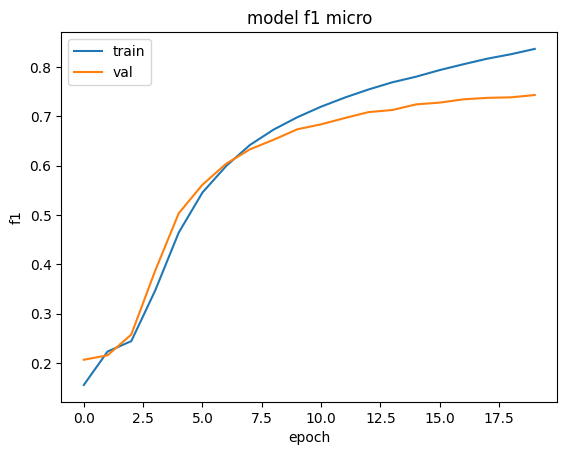

In [104]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Посмотрим еще максимальную f меру

In [105]:
max(f1s_eval)

0.7431729349636584

### CNNs

In [110]:
class Conv1(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim = 100, ker_size = 7, stride = 1, hidden_layer = 64, max_len = 200):
        
        super().__init__() 

        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.KERNEL_SIZE = ker_size
        self.MAX_LEN = max_len
        self.IN_CHANNELS = self.EMB_DIM
        self.OUT_CHANNELS = output_dim
        self.STRIDE = stride
        self.HIDDEN_FC = hidden_layer
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE, ) 
    
        self.relu = nn.ReLU()
        
        
        self.flattened_size = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1)*self.OUT_CHANNELS)
        
        self.fc = nn.Linear(self.flattened_size, 
                            self.HIDDEN_FC)
        
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        
        embedded = self.embedding(text).permute(0, 2, 1)
        
        convoluted = self.relu(self.conv(embedded))
        hidden = torch.flatten(convoluted, 1, -1)
        hidden = self.relu(self.fc(hidden))  
        
        dense_outputs = self.fc_1(hidden) 
        outputs=self.act(dense_outputs) 
        
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Conv1(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [116]:
torchsummary.summary(model, (200, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 200, 100]       3,215,700
            Conv1d-2              [-1, 19, 194]          13,319
              ReLU-3              [-1, 19, 194]               0
            Linear-4                   [-1, 64]         235,968
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 19]           1,235
        LogSoftmax-7                   [-1, 19]               0
Total params: 3,466,222
Trainable params: 3,466,222
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 13.22
Estimated Total Size (MB): 13.43
----------------------------------------------------------------


In [107]:
import gc
from tqdm import tqdm

f1s = []
f1s_eval = []

for i in tqdm(range(EPOCHS)):
    print(i)
    f1s.append(train(model, train_data, optimizer, criterion, 100))
    evl = evaluate(model, valid_data, criterion)
    print('Eval f1-measure: ', evl)
    f1s_eval.append(evl)


model.load_state_dict(model.best_state)
evl = evaluate(model, valid_data, criterion)

with open("models/model_results.txt", "a") as f:
    f.writelines(f"Model {model._get_name()} f1-score is {evl}\n")
torch.save(model, f"models/'{model._get_name()}'.pt")

del model
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

0
Loss: 2.20754679441452; F1 measure: 0.265546875


  5%|▌         | 1/20 [00:05<01:47,  5.66s/it]

Eval f1-measure:  0.4933988870381587
1
Loss: 1.3379059481620788; F1 measure: 0.5824609375


 10%|█         | 2/20 [00:11<01:39,  5.55s/it]

Eval f1-measure:  0.6076123372198667
2
Loss: 0.944161610007286; F1 measure: 0.705


 15%|█▌        | 3/20 [00:16<01:33,  5.48s/it]

Eval f1-measure:  0.6399270328588733
3
Loss: 0.6805279082059861; F1 measure: 0.78921875


 20%|██        | 4/20 [00:22<01:28,  5.53s/it]

Eval f1-measure:  0.6433837447001818
4
Loss: 0.4679592406749725; F1 measure: 0.8594140625


 25%|██▌       | 5/20 [00:27<01:22,  5.51s/it]

Eval f1-measure:  0.6548055629164142
5
Loss: 0.29244456231594085; F1 measure: 0.918984375


 30%|███       | 6/20 [00:33<01:19,  5.65s/it]

Eval f1-measure:  0.6594618318443367
6
Loss: 0.15518462039530279; F1 measure: 0.9659765625


 35%|███▌      | 7/20 [00:39<01:15,  5.81s/it]

Eval f1-measure:  0.6490987942913387
7
Loss: 0.07720282569527626; F1 measure: 0.9873828125


 40%|████      | 8/20 [00:45<01:09,  5.80s/it]

Eval f1-measure:  0.654959352286493
8
Loss: 0.03729600565508008; F1 measure: 0.99640625


 45%|████▌     | 9/20 [00:50<01:02,  5.71s/it]

Eval f1-measure:  0.6534581314354936
9
Loss: 0.01949319667182863; F1 measure: 0.9980078125


 50%|█████     | 10/20 [00:56<00:57,  5.73s/it]

Eval f1-measure:  0.6579653429739551
10
Loss: 0.013073232853785158; F1 measure: 0.998359375


 55%|█████▌    | 11/20 [01:02<00:52,  5.88s/it]

Eval f1-measure:  0.6569089283010296
11
Loss: 0.009517715256661176; F1 measure: 0.9986328125


 60%|██████    | 12/20 [01:09<00:48,  6.03s/it]

Eval f1-measure:  0.6597694105844943
12
Loss: 0.007377194485161454; F1 measure: 0.998984375


 65%|██████▌   | 13/20 [01:15<00:42,  6.07s/it]

Eval f1-measure:  0.6596144382192611
13
Loss: 0.005864523483905941; F1 measure: 0.998984375


 70%|███████   | 14/20 [01:21<00:35,  5.95s/it]

Eval f1-measure:  0.6611203910508782
14
Loss: 0.006070959069766104; F1 measure: 0.9987890625


 75%|███████▌  | 15/20 [01:27<00:29,  6.00s/it]

Eval f1-measure:  0.6624713715172622
15
Loss: 0.00534165833843872; F1 measure: 0.9987109375


 80%|████████  | 16/20 [01:33<00:23,  6.00s/it]

Eval f1-measure:  0.661420871820109
16
Loss: 0.00473865139298141; F1 measure: 0.9990234375


 85%|████████▌ | 17/20 [01:39<00:17,  5.93s/it]

Eval f1-measure:  0.6620206503634161
17
Loss: 0.00460424862918444; F1 measure: 0.9991015625


 90%|█████████ | 18/20 [01:44<00:11,  5.89s/it]

Eval f1-measure:  0.6618727759691097
18
Loss: 0.004278633184731007; F1 measure: 0.9989453125


 95%|█████████▌| 19/20 [01:50<00:05,  5.82s/it]

Eval f1-measure:  0.6627730352816474
19
Loss: 0.009724942580214701; F1 measure: 0.99796875


100%|██████████| 20/20 [01:56<00:00,  5.82s/it]

Eval f1-measure:  0.6605158805269534


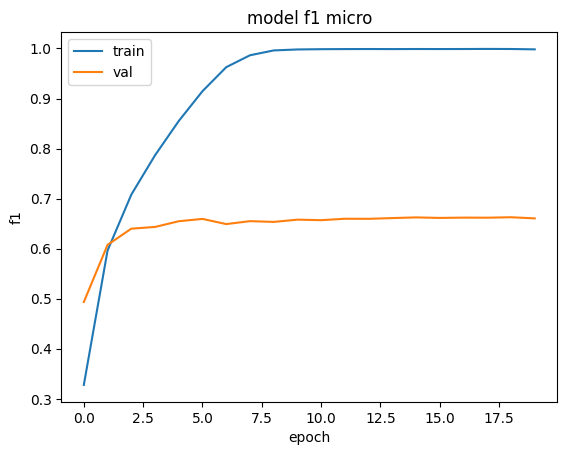

In [117]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [142]:
max(f1s_eval)

0.6627730352816474

Добавим батчнорм и регуляризацию.

In [144]:
class Conv2(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.KERNEL_SIZE = 5
        self.MAX_LEN = 200
        self.IN_CHANNELS = self.EMB_DIM
        self.OUT_CHANNELS = 128
        self.STRIDE = 2
        self.STRIDE_POOL = 2
        self.KERNEL_SIZE_POOL = 2
        self.HIDDEN_FC = 64
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE) 
        self.conv_length = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1))
        
        # инициализируем батчнорм
        self.batch_norm = nn.BatchNorm1d(self.OUT_CHANNELS)

        
        self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE_POOL, 
                                     stride=self.STRIDE_POOL) 
        self.pool_length = int((((self.conv_length-(self.KERNEL_SIZE_POOL-1)-1)/self.STRIDE_POOL)+1))
        
        self.relu = torch.nn.LeakyReLU()
        

        self.fc = nn.Linear(self.OUT_CHANNELS * self.pool_length, 
                            self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        convoluted = self.conv(embedded)
        # я не нашел совсем достоверной информации, но пару авторитетных мнений
        # указывают на то, что батчнорм нужно ставить после свертки-пулинга-активации
        # а не где-то внутри этой тройки
        # то есть нужно держаться структуры свертка-*пулинг*-активация-батчнорм (пулинг опциональный)
        pooled = self.batch_norm(self.relu(self.max_pool(convoluted)), )
        hidden = torch.flatten(pooled, 1, -1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 
        outputs=self.act(dense_outputs)
        
        return outputs



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Conv2(len(label2id))


optimizer = optim.Adam([{'params':model.fc_1.parameters()},
                        {'params':model.conv.parameters()},
                        {'params':model.embedding.parameters()},
                        {'params': model.fc.parameters(), 'weight_decay':0.1}],  # указываем в этом слое L2 регуляризацию
                                                                                 # можно пробовать значения как в sklearn
                                                                                 # в параметре C в логреге
                       
                         lr=0.001) # лернирг рейт тоже можно отдельно указать выше, но мы используем 1 на все слои
criterion = nn.CrossEntropyLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [145]:
torchsummary.summary(model, (200, ), batch_size=256)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1            [256, 200, 100]       3,215,700
            Conv1d-2             [256, 128, 98]          64,128
         MaxPool1d-3             [256, 128, 49]               0
         LeakyReLU-4             [256, 128, 49]               0
       BatchNorm1d-5             [256, 128, 49]             256
            Linear-6                  [256, 64]         401,472
         LeakyReLU-7                  [256, 64]               0
            Linear-8                  [256, 19]           1,235
        LogSoftmax-9                  [256, 19]               0
Total params: 3,682,791
Trainable params: 3,682,791
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 100.64
Params size (MB): 14.05
Estimated Total Size (MB): 114.88
----------------------------------

In [146]:
import gc
from tqdm import tqdm

f1s = []
f1s_eval = []

for i in tqdm(range(EPOCHS)):
    print(i)
    f1s.append(train(model, train_data, optimizer, criterion, 100))
    evl = evaluate(model, valid_data, criterion)
    print('Eval f1-measure: ', evl)
    f1s_eval.append(evl)


model.load_state_dict(model.best_state)
evl = evaluate(model, valid_data, criterion)

with open("models/model_results.txt", "a") as f:
    f.writelines(f"Model {model._get_name()} f1-score is {evl}\n")
torch.save(model, f"models/'{model._get_name()}'.pt")

del model
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

0
Loss: 2.181894739866257; F1 measure: 0.2829296875


  5%|▌         | 1/20 [00:18<05:57, 18.82s/it]

Eval f1-measure:  0.4964107927013931
1
Loss: 1.3699736380577088; F1 measure: 0.5759375


 10%|█         | 2/20 [00:36<05:31, 18.44s/it]

Eval f1-measure:  0.5948324405663235
2
Loss: 1.0419024914503097; F1 measure: 0.6805078125


 15%|█▌        | 3/20 [00:55<05:10, 18.28s/it]

Eval f1-measure:  0.6478838582677166
3
Loss: 0.8429162776470185; F1 measure: 0.7411328125


 20%|██        | 4/20 [01:13<04:51, 18.19s/it]

Eval f1-measure:  0.6591495211235615
4
Loss: 0.6857535374164582; F1 measure: 0.7924609375


 25%|██▌       | 5/20 [01:31<04:32, 18.17s/it]

Eval f1-measure:  0.6806551900363416
5
Loss: 0.569606848359108; F1 measure: 0.8250390625


 30%|███       | 6/20 [01:49<04:13, 18.14s/it]

Eval f1-measure:  0.6911672849788008
6
Loss: 0.47030300348997117; F1 measure: 0.8580859375


 35%|███▌      | 7/20 [02:07<03:55, 18.12s/it]

Eval f1-measure:  0.7075529508631132
7
Loss: 0.37922241240739823; F1 measure: 0.889296875


 40%|████      | 8/20 [02:25<03:37, 18.13s/it]

Eval f1-measure:  0.7037933922622652
8
Loss: 0.31682878389954566; F1 measure: 0.9078515625


 45%|████▌     | 9/20 [02:43<03:20, 18.20s/it]

Eval f1-measure:  0.7095037098728044
9
Loss: 0.26008832424879075; F1 measure: 0.928984375


 50%|█████     | 10/20 [03:02<03:02, 18.20s/it]

Eval f1-measure:  0.7095037098728044
10
Loss: 0.22509958311915398; F1 measure: 0.938671875


 55%|█████▌    | 11/20 [03:20<02:43, 18.17s/it]

Eval f1-measure:  0.7209314430648093
11
Loss: 0.18369358733296395; F1 measure: 0.9537890625


 60%|██████    | 12/20 [03:38<02:25, 18.16s/it]

Eval f1-measure:  0.7243834229254997
12
Loss: 0.158387933075428; F1 measure: 0.96015625


 65%|██████▌   | 13/20 [03:56<02:07, 18.16s/it]

Eval f1-measure:  0.7159628634161114
13
Loss: 0.1382229033857584; F1 measure: 0.96703125


 70%|███████   | 14/20 [04:14<01:48, 18.15s/it]

Eval f1-measure:  0.7216767300121139
14
Loss: 0.11854342244565487; F1 measure: 0.974140625


 75%|███████▌  | 15/20 [04:33<01:31, 18.27s/it]

Eval f1-measure:  0.7305432786947305
15
Loss: 0.11401511885225774; F1 measure: 0.9734375


 80%|████████  | 16/20 [04:51<01:13, 18.26s/it]

Eval f1-measure:  0.7168619397334949
16
Loss: 0.09758889187127352; F1 measure: 0.978671875


 85%|████████▌ | 17/20 [05:09<00:54, 18.26s/it]

Eval f1-measure:  0.7309928168534222
17
Loss: 0.08622520204633474; F1 measure: 0.982734375


 90%|█████████ | 18/20 [05:27<00:36, 18.23s/it]

Eval f1-measure:  0.7213750662477286
18
Loss: 0.08070714376866818; F1 measure: 0.98375


 95%|█████████▌| 19/20 [05:45<00:18, 18.19s/it]

Eval f1-measure:  0.7306923360841915
19
Loss: 0.07240406353026628; F1 measure: 0.98625


100%|██████████| 20/20 [06:04<00:00, 18.20s/it]

Eval f1-measure:  0.7287332961084191


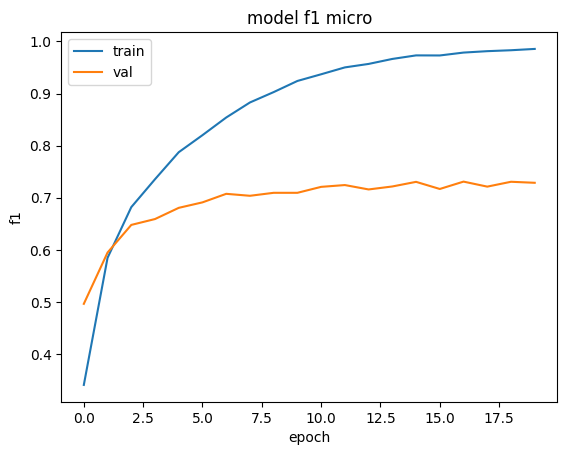

In [147]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [148]:
max(f1s_eval)

0.7309928168534222

### Продолжим добавлять слои

In [263]:
# воспользуюсь удобным шаблоном, добавив пулинг

class Conv_layer_with_pad(nn.Module):
    
    def __init__(self, in_channels, out_channels, *, kernel_size = 5, stride = 1, ):
        
        super().__init__()          
        self.KERNEL_SIZE = kernel_size
        self.IN_CHANNELS = in_channels
        self.OUT_CHANNELS = out_channels
        self.STRIDE = stride
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE, ) 
        self.pool = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.act = nn.LeakyReLU()
        
    def forward(self, embedded):
        """
        Раньше мы расчитывали длину, которая получится, после применения сверточного слоя  по формуле:
        OUTPUT_LENGTH = (((MAX_LEN-(KERNEL_SIZE-1)-1)/STRIDE)+1)
        
        
        Теперь мы хотим на выходе получить длину, которая будет соответствовать длине изначальной последовательности.
        Т.е. мы знаем OUTPUT_LENGTH и наша задача найти такой MAX_LEN, при котором он получается (остальные параметры фиксированы)
        Перенесем все известные значения влево и получится вот такая формула
        ((OUTPUT_LENGTH-1)*STRIDE)+1+(KERNEL_SIZE-1) = MAX_LEN
        
        Используя нужное значение MAX_LEN, нам нужно допаддить изначальную последовательность до этой длины
        Т.к. мы будет падить с двух сторон, то нужно, чтобы получившееся число делилось на 2
        
        
        
        """
        MAX_LEN = embedded.size(2)
        EXP_LEN = ((MAX_LEN-1)*self.STRIDE)+1+(self.KERNEL_SIZE-1)

        assert not (EXP_LEN-MAX_LEN)%2, f"Не ровный паддинг! {EXP_LEN}"
        
        padded = F.pad(embedded, (int((EXP_LEN-MAX_LEN)), 
                                                   int((EXP_LEN-MAX_LEN))))
        
        convoluted = self.pool(self.conv(padded))
        
        return self.act(convoluted)

In [243]:
class Conv3(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim = 75, max_len = 200):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.MAX_LEN = max_len
        self.IN_CHANNELS = self.MAX_LEN
        self.OUT_CHANNELS = output_dim
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.conv = Conv_layer_with_pad(self.EMB_DIM, 192, kernel_size=2, stride=2)
        self.conv1 = Conv_layer_with_pad(192, 48)
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(2400, 
                            3200)
        self.drop = nn.Dropout(p = 0.9)
        self.fc_1 = nn.Linear(3200, 256)
        self.fc_2 = nn.Linear(256, self.OUT_CHANNELS)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        convoluted = self.conv1(self.conv(embedded.permute(0, 2, 1)))
        hidden = torch.flatten(convoluted, 1, -1)
        hidden = torch.relu(self.fc(hidden))
        hidden = self.drop(hidden)
        ffn=self.relu(self.fc_1(hidden))
        outputs=self.act(self.fc_2(ffn))

        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Conv3(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [244]:
torchsummary.summary(model, (200, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1              [-1, 200, 75]       2,411,775
            Conv1d-2             [-1, 192, 200]          28,992
         MaxPool1d-3             [-1, 192, 100]               0
         LeakyReLU-4             [-1, 192, 100]               0
Conv_layer_with_pad-5             [-1, 192, 100]               0
            Conv1d-6              [-1, 48, 100]          46,128
         MaxPool1d-7               [-1, 48, 50]               0
         LeakyReLU-8               [-1, 48, 50]               0
Conv_layer_with_pad-9               [-1, 48, 50]               0
           Linear-10                 [-1, 3200]       7,683,200
          Dropout-11                 [-1, 3200]               0
           Linear-12                  [-1, 256]         819,456
             ReLU-13                  [-1, 256]               0
           Linear-14                 

In [245]:
import gc
from tqdm import tqdm

f1s = []
f1s_eval = []

for i in tqdm(range(EPOCHS)):
    print(i)
    f1s.append(train(model, train_data, optimizer, criterion, 100))
    evl = evaluate(model, valid_data, criterion)
    print('Eval f1-measure: ', evl)
    f1s_eval.append(evl)


model.load_state_dict(model.best_state)
evl = evaluate(model, valid_data, criterion)

with open("models/model_results.txt", "a") as f:
    f.writelines(f"Model {model._get_name()} f1-score is {evl}\n")
torch.save(model, f"models/'{model._get_name()}'.pt")

del model
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

0
Loss: 2.333270890712738; F1 measure: 0.200703125


  5%|▌         | 1/20 [00:17<05:35, 17.65s/it]

Eval f1-measure:  0.28029295692004846
1
Loss: 1.9276797676086426; F1 measure: 0.3166796875


 10%|█         | 2/20 [00:35<05:19, 17.72s/it]

Eval f1-measure:  0.36430927278921865
2
Loss: 1.6480335485935211; F1 measure: 0.4182421875


 15%|█▌        | 3/20 [00:53<05:02, 17.77s/it]

Eval f1-measure:  0.4444122406874621
3
Loss: 1.393030412197113; F1 measure: 0.5312109375


 20%|██        | 4/20 [01:10<04:43, 17.72s/it]

Eval f1-measure:  0.5502027653694731
4
Loss: 1.2083557534217835; F1 measure: 0.60765625


 25%|██▌       | 5/20 [01:28<04:25, 17.69s/it]

Eval f1-measure:  0.5840115838885525
5
Loss: 1.021915095448494; F1 measure: 0.671875


 30%|███       | 6/20 [01:46<04:07, 17.67s/it]

Eval f1-measure:  0.6133262038158691
6
Loss: 0.8821213001012802; F1 measure: 0.7130859375


 35%|███▌      | 7/20 [02:03<03:49, 17.65s/it]

Eval f1-measure:  0.6220377801332526
7
Loss: 0.7669698399305344; F1 measure: 0.75109375


 40%|████      | 8/20 [02:21<03:31, 17.66s/it]

Eval f1-measure:  0.6184402918685645
8
Loss: 0.6655414882302284; F1 measure: 0.7791015625


 45%|████▌     | 9/20 [02:39<03:14, 17.66s/it]

Eval f1-measure:  0.6245906836765597
9
Loss: 0.5822508776187897; F1 measure: 0.8074609375


 50%|█████     | 10/20 [02:57<02:57, 17.78s/it]

Eval f1-measure:  0.5997939222440946
10
Loss: 0.5506222754716873; F1 measure: 0.8181640625


 55%|█████▌    | 11/20 [03:14<02:39, 17.73s/it]

Eval f1-measure:  0.6173862431859478
11
Loss: 0.42251779198646544; F1 measure: 0.8584765625


 60%|██████    | 12/20 [03:32<02:21, 17.71s/it]

Eval f1-measure:  0.5846089964415506
12
Loss: 0.3739192879199982; F1 measure: 0.8753125


 65%|██████▌   | 13/20 [03:50<02:03, 17.70s/it]

Eval f1-measure:  0.6200846551332526
13
Loss: 0.3043846347928047; F1 measure: 0.896640625


 70%|███████   | 14/20 [04:07<01:46, 17.68s/it]

Eval f1-measure:  0.6181291641429437
14
Loss: 0.2750784407556057; F1 measure: 0.9081640625


 75%|███████▌  | 15/20 [04:25<01:28, 17.69s/it]

Eval f1-measure:  0.6274535319503332
15
Loss: 0.24373523250222207; F1 measure: 0.9173046875


 80%|████████  | 16/20 [04:43<01:10, 17.67s/it]

Eval f1-measure:  0.6199367807389462
16
Loss: 0.2000244077295065; F1 measure: 0.934453125


 85%|████████▌ | 17/20 [05:00<00:52, 17.66s/it]

Eval f1-measure:  0.6173755962295578
17
Loss: 0.1825265371054411; F1 measure: 0.9400390625


 90%|█████████ | 18/20 [05:18<00:35, 17.66s/it]

Eval f1-measure:  0.5995040884312538
18
Loss: 0.1677310836315155; F1 measure: 0.9438671875


 95%|█████████▌| 19/20 [05:36<00:17, 17.66s/it]

Eval f1-measure:  0.6124223955178679
19
Loss: 0.14410950250923635; F1 measure: 0.9522265625


100%|██████████| 20/20 [05:53<00:00, 17.69s/it]

Eval f1-measure:  0.6221856545275591


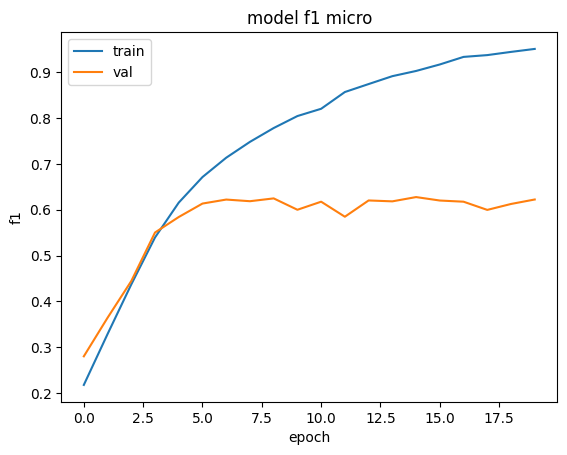

In [246]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [247]:
max(f1s_eval)

0.6274535319503332

### V4

In [266]:
class Conv4(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim = 125, max_len = 200):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.MAX_LEN = max_len
        self.IN_CHANNELS = self.MAX_LEN
        self.OUT_CHANNELS = output_dim
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p = 0.2)
        
        self.conv1 = nn.Sequential(*[Conv_layer_with_pad(self.EMB_DIM, 192, kernel_size=2, stride=2),
                                    nn.BatchNorm1d(192)])
        self.conv2 = nn.Sequential(*[Conv_layer_with_pad(192, 384, kernel_size=3, stride=1),
                                    nn.BatchNorm1d(384)])
        self.conv3 = nn.Sequential(*[Conv_layer_with_pad(384, 48, kernel_size=3, stride=1),
                                    nn.BatchNorm1d(48)])
        self.fc = nn.Linear(1872, 
                            3200)
        self.fc_1 = nn.Linear(3200, 256)
        self.fc_2 = nn.Linear(256, self.OUT_CHANNELS)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        convoluted = self.conv1(embedded.permute(0, 2, 1))
        convoluted = self.conv2(convoluted)
        convoluted = self.conv3(convoluted)
        hidden = torch.flatten(convoluted, 1, -1)
        hidden = torch.relu(self.fc(hidden))
        hidden = self.drop(hidden)
        ffn=self.relu(self.fc_1(hidden))
        outputs=self.act(self.fc_2(ffn))

        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Conv4(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [267]:
torchsummary.summary(model, (200, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 200, 125]       4,019,625
            Conv1d-2             [-1, 192, 300]          48,192
         MaxPool1d-3             [-1, 192, 150]               0
         LeakyReLU-4             [-1, 192, 150]               0
Conv_layer_with_pad-5             [-1, 192, 150]               0
       BatchNorm1d-6             [-1, 192, 150]             384
            Conv1d-7             [-1, 384, 152]         221,568
         MaxPool1d-8              [-1, 384, 76]               0
         LeakyReLU-9              [-1, 384, 76]               0
Conv_layer_with_pad-10              [-1, 384, 76]               0
      BatchNorm1d-11              [-1, 384, 76]             768
           Conv1d-12               [-1, 48, 78]          55,344
        MaxPool1d-13               [-1, 48, 39]               0
        LeakyReLU-14               [

In [268]:
import gc
from tqdm import tqdm

f1s = []
f1s_eval = []

for i in tqdm(range(EPOCHS)):
    print(i)
    f1s.append(train(model, train_data, optimizer, criterion, 100))
    evl = evaluate(model, valid_data, criterion)
    print('Eval f1-measure: ', evl)
    f1s_eval.append(evl)


model.load_state_dict(model.best_state)
evl = evaluate(model, valid_data, criterion)

with open("models/model_results.txt", "a") as f:
    f.writelines(f"Model {model._get_name()} f1-score is {evl}\n")
torch.save(model, f"models/'{model._get_name()}'.pt")

del model
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

0
Loss: 2.215587409734726; F1 measure: 0.259296875


  5%|▌         | 1/20 [00:38<12:02, 38.04s/it]

Eval f1-measure:  0.3217664010448213
1
Loss: 1.5226519060134889; F1 measure: 0.509140625


 10%|█         | 2/20 [01:10<10:27, 34.84s/it]

Eval f1-measure:  0.5460078645517868
2
Loss: 1.1761188966035843; F1 measure: 0.6202734375


 15%|█▌        | 3/20 [01:43<09:34, 33.77s/it]

Eval f1-measure:  0.5786147599939431
3
Loss: 0.9429487323760987; F1 measure: 0.702578125


 20%|██        | 4/20 [02:13<08:41, 32.56s/it]

Eval f1-measure:  0.5279624564657783
4
Loss: 0.7167835921049118; F1 measure: 0.7728515625


 25%|██▌       | 5/20 [02:44<07:57, 31.80s/it]

Eval f1-measure:  0.548545389158086
5
Loss: 0.5629215258359909; F1 measure: 0.817734375


 30%|███       | 6/20 [03:15<07:20, 31.48s/it]

Eval f1-measure:  0.5369768795427015
6
Loss: 0.4523720481991768; F1 measure: 0.850859375


 35%|███▌      | 7/20 [03:46<06:49, 31.49s/it]

Eval f1-measure:  0.5817532461387038
7
Loss: 0.33659362465143206; F1 measure: 0.8890234375


 40%|████      | 8/20 [04:17<06:15, 31.33s/it]

Eval f1-measure:  0.5997974712295578
8
Loss: 0.2535774493217468; F1 measure: 0.914765625


 45%|████▌     | 9/20 [04:48<05:42, 31.13s/it]

Eval f1-measure:  0.5945414237583283
9
Loss: 0.1962707855552435; F1 measure: 0.9356640625


 50%|█████     | 10/20 [05:18<05:09, 30.97s/it]

Eval f1-measure:  0.6040160319503332
10
Loss: 0.1708233116567135; F1 measure: 0.943984375


 55%|█████▌    | 11/20 [05:49<04:37, 30.84s/it]

Eval f1-measure:  0.5867206427922471
11
Loss: 0.12342333056032657; F1 measure: 0.9579296875


 60%|██████    | 12/20 [06:20<04:06, 30.79s/it]

Eval f1-measure:  0.5847746157631739
12
Loss: 0.11030529759824276; F1 measure: 0.9642578125


 65%|██████▌   | 13/20 [06:50<03:34, 30.71s/it]

Eval f1-measure:  0.61453285887341
13
Loss: 0.09297590959817172; F1 measure: 0.9681640625


 70%|███████   | 14/20 [07:21<03:04, 30.68s/it]

Eval f1-measure:  0.6016027218352513
14
Loss: 0.08617604011669755; F1 measure: 0.9717578125


 75%|███████▌  | 15/20 [07:52<02:34, 30.81s/it]

Eval f1-measure:  0.5852265199121744
15
Loss: 0.06262344870716334; F1 measure: 0.97875


 80%|████████  | 16/20 [08:23<02:03, 30.97s/it]

Eval f1-measure:  0.5918394628255602
16
Loss: 0.0609178410936147; F1 measure: 0.979765625


 85%|████████▌ | 17/20 [08:55<01:33, 31.24s/it]

Eval f1-measure:  0.6071698970321018
17
Loss: 0.06454542370513082; F1 measure: 0.9782421875


 90%|█████████ | 18/20 [09:27<01:02, 31.31s/it]

Eval f1-measure:  0.5817709910660206
18
Loss: 0.05128126232419163; F1 measure: 0.9826953125


 95%|█████████▌| 19/20 [09:57<00:31, 31.18s/it]

Eval f1-measure:  0.613035187007874
19
Loss: 0.048601707704365255; F1 measure: 0.9841796875


100%|██████████| 20/20 [10:28<00:00, 31.43s/it]

Eval f1-measure:  0.5458493432010902


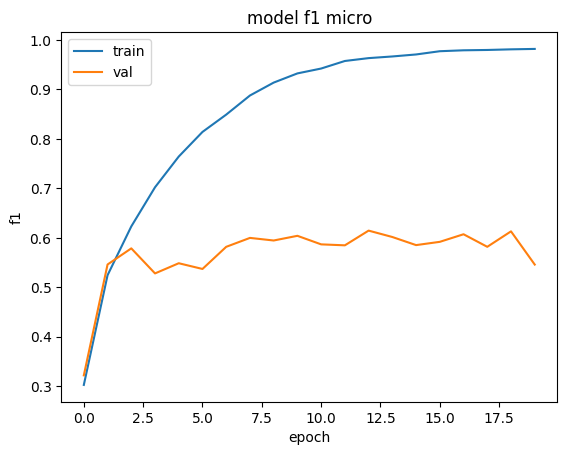

In [269]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [270]:
max(f1s_eval)

0.61453285887341

### V5

In [291]:
class Conv5(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim = 300, max_len = 200):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.MAX_LEN = max_len
        self.IN_CHANNELS = self.MAX_LEN
        self.OUT_CHANNELS = output_dim
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU6()
        self.drop = nn.Dropout(p = 0.2)
        
        self.conv1 = nn.Sequential(*[Conv_layer_with_pad(self.EMB_DIM, 192, kernel_size=2, stride=2),
                                    nn.BatchNorm1d(192)])
        self.conv2 = nn.Sequential(*[Conv_layer_with_pad(192, 512, kernel_size=1, stride=1),
                                    nn.BatchNorm1d(512)])
        self.conv3 = nn.Sequential(*[Conv_layer_with_pad(512, 96, kernel_size=3, stride=1),
                                    nn.BatchNorm1d(96)])
        self.conv4 = nn.Sequential(*[Conv_layer_with_pad(96, 16, kernel_size=5, stride=2),
                                    nn.BatchNorm1d(16)])
        self.fc = nn.Linear(480, 
                            3200)
        self.fc_1 = nn.Linear(3200, 256)
        self.fc_2 = nn.Linear(256, self.OUT_CHANNELS)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        convoluted = self.conv1(embedded.permute(0, 2, 1))
        convoluted = self.conv2(convoluted)
        convoluted = self.conv3(convoluted)
        convoluted = self.conv4(convoluted)
        hidden = torch.flatten(convoluted, 1, -1)
        hidden = self.drop(hidden)
        hidden = self.relu(self.fc(hidden))
        hidden=self.relu(self.fc_1(hidden))
        outputs=self.act(self.fc_2(hidden))

        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Conv5(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [292]:
torchsummary.summary(model, (200, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 200, 300]       9,647,100
            Conv1d-2             [-1, 192, 300]         115,392
         MaxPool1d-3             [-1, 192, 150]               0
         LeakyReLU-4             [-1, 192, 150]               0
Conv_layer_with_pad-5             [-1, 192, 150]               0
       BatchNorm1d-6             [-1, 192, 150]             384
            Conv1d-7             [-1, 512, 150]          98,816
         MaxPool1d-8              [-1, 512, 75]               0
         LeakyReLU-9              [-1, 512, 75]               0
Conv_layer_with_pad-10              [-1, 512, 75]               0
      BatchNorm1d-11              [-1, 512, 75]           1,024
           Conv1d-12               [-1, 96, 77]         147,552
        MaxPool1d-13               [-1, 96, 39]               0
        LeakyReLU-14               [

In [293]:
import gc
from tqdm import tqdm

f1s = []
f1s_eval = []

for i in tqdm(range(EPOCHS)):
    print(i)
    f1s.append(train(model, train_data, optimizer, criterion, 100))
    evl = evaluate(model, valid_data, criterion)
    print('Eval f1-measure: ', evl)
    f1s_eval.append(evl)


model.load_state_dict(model.best_state)
evl = evaluate(model, valid_data, criterion)

with open("models/model_results.txt", "a") as f:
    f.writelines(f"Model {model._get_name()} f1-score is {evl}\n")
torch.save(model, f"models/'{model._get_name()}'.pt")

del model
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

0
Loss: 2.0702502238750458; F1 measure: 0.2845703125


  5%|▌         | 1/20 [00:51<16:27, 51.95s/it]

Eval f1-measure:  0.4041300726832223
1
Loss: 1.4034577345848083; F1 measure: 0.5290234375


 10%|█         | 2/20 [01:35<14:09, 47.17s/it]

Eval f1-measure:  0.5219540240763174
2
Loss: 1.073028223514557; F1 measure: 0.6496484375


 15%|█▌        | 3/20 [02:18<12:49, 45.26s/it]

Eval f1-measure:  0.5808671827680194
3
Loss: 0.8172006577253341; F1 measure: 0.7380859375


 20%|██        | 4/20 [03:01<11:50, 44.39s/it]

Eval f1-measure:  0.5987528865081768
4
Loss: 0.6258792904019356; F1 measure: 0.8035546875


 25%|██▌       | 5/20 [03:44<10:57, 43.85s/it]

Eval f1-measure:  0.5502074973500909
5
Loss: 0.47532449156045914; F1 measure: 0.852265625


 30%|███       | 6/20 [04:27<10:09, 43.54s/it]

Eval f1-measure:  0.6017612431859479
6
Loss: 0.375085788667202; F1 measure: 0.8812890625


 35%|███▌      | 7/20 [05:10<09:23, 43.36s/it]

Eval f1-measure:  0.6115256851907934
7
Loss: 0.28603634402155875; F1 measure: 0.9131640625


 40%|████      | 8/20 [05:53<08:39, 43.27s/it]

Eval f1-measure:  0.6244510902483343
8
Loss: 0.23195462107658385; F1 measure: 0.930078125


 45%|████▌     | 9/20 [06:37<07:58, 43.53s/it]

Eval f1-measure:  0.6265497236523319
9
Loss: 0.19783558055758477; F1 measure: 0.940703125


 50%|█████     | 10/20 [07:23<07:20, 44.09s/it]

Eval f1-measure:  0.6268466554360993
10
Loss: 0.16153275668621064; F1 measure: 0.9513671875


 55%|█████▌    | 11/20 [08:07<06:38, 44.23s/it]

Eval f1-measure:  0.6161831371138704
11
Loss: 0.1347066418454051; F1 measure: 0.9606640625


 60%|██████    | 12/20 [08:51<05:51, 43.97s/it]

Eval f1-measure:  0.6346686193973349
12
Loss: 0.10836652237921954; F1 measure: 0.967578125


 65%|██████▌   | 13/20 [09:34<05:05, 43.70s/it]

Eval f1-measure:  0.6187407726377953
13
Loss: 0.0985555574670434; F1 measure: 0.970703125


 70%|███████   | 14/20 [10:17<04:21, 43.51s/it]

Eval f1-measure:  0.6149800310417929
14
Loss: 0.09300660233944655; F1 measure: 0.9740234375


 75%|███████▌  | 15/20 [11:00<03:37, 43.48s/it]

Eval f1-measure:  0.6447359081617202
15
Loss: 0.09543121531605721; F1 measure: 0.971328125


 80%|████████  | 16/20 [11:43<02:53, 43.35s/it]

Eval f1-measure:  0.6325628880224107
16
Loss: 0.08389352921396494; F1 measure: 0.9741015625


 85%|████████▌ | 17/20 [12:26<02:09, 43.32s/it]

Eval f1-measure:  0.6506023811326469
17
Loss: 0.06344236980192364; F1 measure: 0.9815625


 90%|█████████ | 18/20 [13:10<01:26, 43.26s/it]

Eval f1-measure:  0.6388836311326469
18
Loss: 0.058304929621517655; F1 measure: 0.981875


 95%|█████████▌| 19/20 [13:53<00:43, 43.32s/it]

Eval f1-measure:  0.6118190679890975
19
Loss: 0.07311855807900429; F1 measure: 0.9774609375


100%|██████████| 20/20 [14:36<00:00, 43.84s/it]

Eval f1-measure:  0.6402263306329498


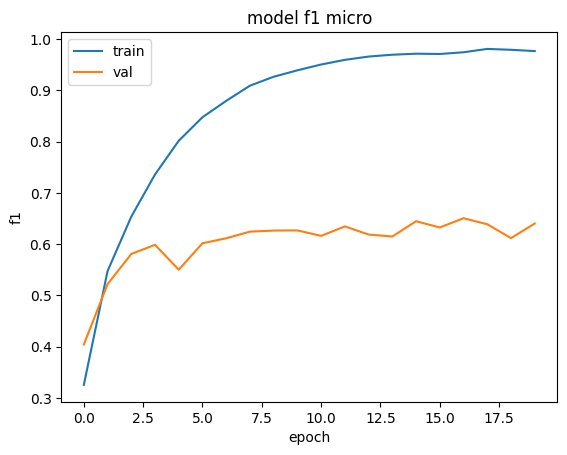

In [294]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [295]:
max(f1s_eval)

0.6506023811326469